# EDA of Sim data

Validating behavioral expectations of simulation with session data. 
Specifically focusing on On-task/Off-task and total session time-on-task. 

## Setup

In [ ]:
import sys
sys.path.append("../lib")

In [2]:
import math
import random
import uuid
import os
import copy
import itertools
from collections.abc import Iterable
import datetime as dt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import Bounds
from scipy.optimize import minimize
from scipy import optimize
from scipy.stats import pearsonr

from sklearn.cluster import DBSCAN
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import FactorAnalysis

from factor_analyzer.factor_analyzer import calculate_kmo
from factor_analyzer import FactorAnalyzer

import statsmodels.api as sm



In [3]:
import logging

#logging.basicConfig(level=logging.DEBUG)
logging.basicConfig(level=logging.INFO)
#logging.basicConfig(level=logging.WARNING)

logger = logging.getLogger("main")

In [4]:
#logging.getLogger().setLevel(logging.DEBUG)
logging.getLogger().setLevel(logging.INFO)
#logging.getLogger().setLevel(logging.WARNING)
logger.debug("Test debug")
logger.info("Test info")
logger.warning("Test warning")

INFO:main:Test info


In [5]:
# from tutor.domain import Domain
from tutor.curriculum_factory import CurriculumFactory
from tutor.simple_curriculum import SimpleCurriculum
from tutor.tutor import SimpleTutor
from tutor.action import Attempt, HintRequest

In [6]:
from learner.selfeff_learner import SelfEfficacyLearner
from learner.modular_learner import ModularLearner
from learner.cognition import *
from learner.decider import *

In [7]:
from simulate.modlearner_simulation import ModLearnerSimulation
from simulate.simulation import *

In [8]:
from analytics.student_stats import *
from analytics.cae import *
from analytics.featurization import *
from analytics.batch import *

In [9]:
from log_db import mongo
from log_db.curriculum_mapper import DB_Curriculum_Mapper
from log_db.learner_mapper import DBLearnerMapper

In [10]:
from CanonicalAutocorrelationAnalysis.model.caa import CAAComputation
from CanonicalAutocorrelationAnalysis.model.caaObject import *
from CanonicalAutocorrelationAnalysis.model.utils import l1Norm, l2Norm, r2Compute

In [11]:
# Get path to current project directory
cwd = os.path.abspath(".")
base_dir = os.path.abspath(os.path.join(cwd, os.pardir))
logger.info("Base directory for the project:\n%s" % base_dir)

INFO:analytics.batch:Base directory for the project:
/rdata/Sandbox/MotivSim


In [12]:
# Setup connection to database
data_out = "sim-%s" % str(uuid.uuid4())
data_path = os.path.join(base_dir,"test", "data", data_out)
logger.info("Writing simulation results to directory: %s" % data_path)
db_name = "motivsim"
db_params  = mongo.get_db_params(db_name)
logger.info("got db params: %s" % str(db_params))
db_util = mongo.Data_Utility(data_path, db_params)
db = db_util.db

INFO:analytics.batch:Writing simulation results to directory: /rdata/Sandbox/MotivSim/test/data/sim-db66afb1-27e2-4851-a188-f2f2836fe5e8
INFO:analytics.batch:got db params: {'settingId': 'motivsim', 'url': 'localhost', 'port': '27017', 'name': 'motivsim', 'user': '', 'pswd': ''}


In [13]:
# Test db connection
db_util.peak()

INFO:log_db.mongo:collection name, kcs, has 596 documents
INFO:log_db.mongo:collection name, caa_batches, has 0 documents
INFO:log_db.mongo:collection name, simbatches, has 1 documents
INFO:log_db.mongo:collection name, sessions, has 400 documents
INFO:log_db.mongo:collection name, caa_models, has 0 documents
INFO:log_db.mongo:collection name, domains, has 1 documents
INFO:log_db.mongo:collection name, students, has 20 documents
INFO:log_db.mongo:collection name, units, has 20 documents
INFO:log_db.mongo:collection name, decisions, has 58101 documents
INFO:log_db.mongo:collection name, curriculums, has 1 documents
INFO:log_db.mongo:collection name, steps, has 70380 documents
INFO:log_db.mongo:collection name, finalsimstudents, has 20 documents
INFO:log_db.mongo:collection name, problems, has 16764 documents
INFO:log_db.mongo:collection name, actions, has 58101 documents
INFO:log_db.mongo:collection name, sections, has 80 documents
INFO:log_db.mongo:collection name, tutor_events, has 41

In [14]:
clear_db = True
if clear_db:
    logger.info("Clearing database before starting new simulation")
    db_util.clear_db()
else:
    logger.info("Skipping Clearing database")

INFO:analytics.batch:Clearing database before starting new simulation


## 1. Simulating learners

In [15]:
num_students = 20
num_sessions = 20

In [16]:
def get_cog_params():
    ability = -2
    while (ability < -1) or (ability > 1):
        ability = np.random.normal(0, 0.6)
    return {"ability": ability}

def gen_students(num_students, domain, curric, 
                 cog_mod, cog_params, dec_mod, dec_params):
    stus = []
    for i in range(num_students):
        cp = cog_params()
        cog = cog_mod(domain, **cp)
        dp = dec_params()
        dec = dec_mod(**dp)
        ### Tmp double off-task value ###
        dec.values['off task'] = 5*dec.values['off task']
        decider = DiligentDecider(dec)
        stu = ModularLearner(domain, cog, decider)
        stus.append(stu)
        
    return stus

def simulate_students(curric, students, batch):    
    
    env = simpy.Environment()

    mastery_thres = 0.95
    m_ses_len = 45
    sd_ses_len = 8
    max_ses_len = 60
    sim_start = dt.datetime.now()

    mod = round(len(students) / 10)
    for i, stu in enumerate(students):
        if i % mod == 0:
            logger.info("Simulating student #%i" % i)
        # Create associated tutor
        tutor = SimpleTutor(curric, stu._id, mastery_thres)

        # Initialize simulation processes
        sim = SingleStudentSim(db, env, sim_start, stu, tutor,
                               num_sessions, m_ses_len, sd_ses_len, max_ses_len)
        batch.add_sim(sim)

        env.process(sim.run())

    env.run()
                
    logger.info("Inserting %i simulated students to db" % len(students))
    result = db.finalsimstudents.insert_many([stu.to_dict() for stu in students])
    logger.info("Db insert success: %s" % result.acknowledged)

    logger.info("Inserting simulation batch to db")
    result = db.simbatches.insert_one(batch.to_dict())
    logger.info("Db insert success: %s" % result.acknowledged)

    return batch, students


In [17]:
new_curric = None
new_domain = None

In [18]:
def get_domain_params(params=None):
    if params is None:
        #params = [0.7 , 0.05, 0.05, 0.01, 0.15, 0.05, 0.3 , 0.1 , 0.5 , 0.02]
        params = [0.4 , 0.1, 0.1, 0.03, 0.1, 0.05, 0.1 , 0.05 , 0.1 , 0.07]
    param_keys = ['m_l0', 'sd_l0', 'm_l0_sd', 'sd_l0_sd', 'm_t',
                'sd_t', 'm_s','sd_s', 'm_g', 'sd_g']
    domain_params = {k:v for k,v in zip(param_keys, params)}
    return domain_params

def gen_test_curric(db, db_params):
    global new_curric, new_domain
    if new_curric is None:
        logger.info("Generating new curriculum")
        
        domain_params = get_domain_params()


        curric_params = {'num_units': 20,
                         'mean_sections': 4,
                         'stdev_sections': 2,
                         'mean_unit_kcs': 22,
                         'stdev_unit_kcs': 23,
                         'section_kcs_lambda': 6,
                         'mean_steps': 10,
                         'stdev_steps': 4,
                         'mean_prob_kcs': 6,
                         'stdev_prob_kcs': 3,
                         'num_practice': 100
                        }

        domain, curric = CurriculumFactory.gen_curriculum(domain_params, curric_params)
        db.domains.insert_one(domain.to_dict())
        db.kcs.insert_many([kc.__dict__ for kc in domain.kcs])
        curric_util = DB_Curriculum_Mapper(db_params)
        curric_util.write_to_db(curric)
        
        new_curric = curric
        new_domain = domain

        return domain, curric
    else:
        logger.info("New curriculum already generated")
        return new_domain, new_curric

In [19]:
def get_sim_batch(desc):
    simbatch = db.simbatches.find_one({"desc": desc})
    if simbatch is None:
        logger.info("Generating new simulation. None found in db")

        # generate simualted data for test
        domain, curric = gen_test_curric(db, db_params)
        students = gen_students(num_students, domain, curric, 
                                cog_mod, get_cog_params, 
                                dec_mod, get_dec_params)   
        logger.info(f"Persisting {len(students)} initialized students to db")
        db.students.insert_many([stu.to_dict() for stu in students])
        batch = SimulationBatch(desc)
        simulate_students(curric, students, batch)    
        logger.info(f"Simulated {len(students)} in batch with id: {batch._id}")
    else:
        logger.info(f"Found simulation batch: {str(simbatch['desc'])}")
        lmapper = DBLearnerMapper(db)
        students = [lmapper.get_modlearner_from_db(sid) for sid in simbatch['student_ids']]
        batch = SimulationBatch.from_dict(simbatch)
        logger.info(f"Recovered {len(students)} students from batch with id: {batch._id}")
        
    return students, batch

### Simple Diligent students

In [20]:
sim_batch_desc = "Simple diligent students"
cog_mod = BiasSkillCognition
dec_mod = EVDecider

def get_cog_params():
    # Helper for getting parameters for BiasSkillCognition Module
    return {'ability': random.triangular(-1,1)}

def get_dec_params():
    return {}

In [21]:
students, batch = get_sim_batch(sim_batch_desc)

INFO:analytics.batch:Generating new simulation. None found in db
INFO:analytics.batch:Generating new curriculum
INFO:tutor.cogtutor_curriculum:Generated 20 units with with a total of 663 kcs
INFO:log_db.curriculum_mapper:Writing curriculum with id, 5113f829-a5b1-4309-a647-724896ed36f4, to db
INFO:log_db.curriculum_mapper:Writing 18732 problem to db
INFO:log_db.curriculum_mapper:Writing 78369 steps to db
INFO:analytics.batch:Persisting 20 initialized students to db
INFO:analytics.batch:Simulating student #0
INFO:analytics.batch:Simulating student #2
INFO:analytics.batch:Simulating student #4
INFO:analytics.batch:Simulating student #6
INFO:analytics.batch:Simulating student #8
INFO:analytics.batch:Simulating student #10
INFO:analytics.batch:Simulating student #12
INFO:analytics.batch:Simulating student #14
INFO:analytics.batch:Simulating student #16
INFO:analytics.batch:Simulating student #18
INFO:analytics.batch:Inserting 20 simulated students to db
INFO:analytics.batch:Db insert succes

## EDA

### Setup

In [22]:
def get_stu_parameters(sids, mastery_thres):
    sim_students = calc.get_stu_attributes(sids)
    sim_students = pd.concat([sim_students, calc.get_mastery(sids, mastery_thres)], axis=1)
    return sim_students


In [23]:
def get_tx_fields(sids, fields=None):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sids}, "type": "TutorInput"}))
    # Add kc field that reduces list of kcs to 1 kc
    tx['kc'] = tx.apply(lambda x: x['kcs'][0]['_id'], axis=1)
    if fields is None:
        return tx
    else:
        return tx.loc[:, fields]

In [24]:
def get_tx(sids):
    tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, 'type': "TutorInput"}))
    tx.index = tx['_id']
    tx['kc'] = tx.explode('kcs')['kcs'].apply(lambda x: x['_id'])
    return tx

def lbl_nondil_tx(tx):
    detector = Detector(db) 
    gt_lblr = TransactionAnnotator(db)
    
    kc_long_tx = detector.get_kc_long_cutoff(tx)
    kc_short_tx = detector.get_kc_short_cutoff(tx)

    # Add Ground truth labels (using global db var)

    tx['is_offtask'] = gt_lblr.label_offtask_tx(tx)
    tx['is_guess'] = gt_lblr.label_guess_tx(tx)

    # Add detector labels
    tx['detect_offtask'] = detector.is_off_task(tx, kc_stats=kc_long_tx)
    tx['detect_guess'] = detector.is_guess(tx, kc_stats=kc_short_tx)
    return tx
    


In [25]:
def calc_accuracy(tx_stats):
    d =  tx_stats['Correct']/ tx_stats['Total Tx']
    d.rename("accuracy", inplace=True)
    return d

def calc_err_on_1_opp(tx):
    d = tx[tx['attempt'] == 0]
    # Get 1st opportunity
    cols = [col for col in d.columns if col not in ['stu_id', 'kc']]
    opp1 = d.groupby(['stu_id', 'kc']).apply(lambda x: x.iloc[0][cols]).reset_index()
    opp1['is_correct'] = opp1['outcome'] == "Correct"
    ## Calculate P(Correct) per student
    opp1 =  opp1.groupby('stu_id')['is_correct'].apply(lambda x: np.sum(x) / len(x))
    opp1.rename("err_on_1_opp", inplace=True)
    return opp1

def calc_avg_prac_opp(tx, mastery_thres=0.9):
    # Get the learner knowledge at the end of each practice step
    d = tx.groupby(['stu_id', 'kc', 'step_id'])['plt1'].apply(lambda x: x[-1]).reset_index()
    d['has_mastered'] = d['plt1'] >= mastery_thres
    # Getting student-kc pairings for analysis
    stu_kc = d.loc[d['has_mastered'], ['stu_id','kc']].drop_duplicates()
    # Get just tx for relevant stu-kc's
    d = pd.merge(tx, stu_kc, on=['stu_id', 'kc'], how='inner')
    d = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
    d = d.groupby('stu_id')['step_id'].mean()
    d.rename('avg_prac_opp', inplace=True)
    return d

def calc_p_guess(tx):
    d = tx.groupby('stu_id')['detect_guess'].apply(lambda x: np.sum(x) / len(x))
    d.rename("p_guess", inplace=True)
    return d

def calc_detected_offtask(tx):
    if "detect_offtask" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_offtask'].mean()

    d.rename("mean_detect_offtask", inplace=True)
    return d

def calc_detected_guess(tx):
    if "detect_guess" not in tx:
        tx = lbl_nondil_tx(tx)
    # Student-level off-task vs detected off-task
    d = tx.groupby("stu_id")['detect_guess'].mean()

    d.rename("mean_detect_guess", inplace=True)
    return d

def calc_time_on_task(tx):
    d = tx.pivot_table(index="stu_id", columns="is_offtask", values="duration", fill_value=0, aggfunc=np.sum).reset_index()
    d.index = d['stu_id']
    d.rename(columns={False: "time_on_task", True: "time_off_task"}, inplace=True)
    d.drop(columns=['stu_id'], inplace=True)
    d['time_on_task'] = d['time_on_task'] / 3600
    d['time_off_task'] = d['time_off_task'] / 3600
    return d

    
    


In [26]:
# Calculating stats with analytic methods

calc = StudentStatCalc(db)
batch_calc = BatchCalculator()
detector = Detector(db)
gt_lblr = TransactionAnnotator(db)

In [27]:
# Get students batches
batches = [batch for batch in db.simbatches.find()]
batch_descs = ["Simple diligent students",
              ]
sids = {desc: [] for desc in batch_descs}
for i, batch in enumerate(batches):
    logger.info(f"batch #{i}: \nID: {batch['_id']}\ndesc: {batch['desc']}")
    if batch['desc'] in batch_descs:
        logger.info(f"recovered {len(batch['student_ids'])} student ids for batch {batch['desc']}")
        sids[batch['desc']].append(batch['student_ids'])

INFO:analytics.batch:batch #0: 
ID: e25af786-4bc3-4cfd-b2e4-0a26fed427b8
desc: Simple diligent students
INFO:analytics.batch:recovered 20 student ids for batch Simple diligent students


In [28]:

stu_stats = {desc: {} for desc in batch_descs}
mastery_thres = 0.9
stu_prob_stats = {desc: {} for desc in batch_descs}
kc_stats = {desc: {} for desc in batch_descs}
for desc in batch_descs:

    sid = sids[desc][0]
    logger.info(f"EDA of {len(sid)} students")
    
    logger.info(f"Calculating for student set:\t{desc}")
    args = [get_stu_parameters, sid, 10, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")

    mastery_thres = 0.9
    args = [get_stu_parameters, sid, 10, [mastery_thres]]
    sim_students, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student params: {sim_students.shape}\tRuntime: {runtime} seconds")
    
    args = [calc.get_action_counts, sid, 10]
    action_dist, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student action stats: {action_dist.shape}\tRuntime: {runtime} seconds")

    args = [calc.total_tx_stats, sid, 10]
    tx_stats, runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
    logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
#     args = [calc.get_stu_prob_stats, sid, 10]
#     stu_prob_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
#     args = [calc.stu_kc_stats, sid, 10]
#     kc_stats[desc], runtime = batch_calc.time_calc(batch_calc.batch_calc, args)
#     logger.info(f"Calculated student activity stats: {tx_stats.shape}\tRuntime: {runtime} seconds")
    
    

    stu_stats[desc] = pd.concat([sim_students, action_dist, tx_stats], axis=1)
    logger.info(f"Merged new stats together: {stu_stats[desc].shape}")


INFO:analytics.batch:EDA of 20 students
INFO:analytics.batch:Calculating for student set:	Simple diligent students
INFO:analytics.batch:Calculated student params: (20, 18)	Runtime: 0.111653 seconds
INFO:analytics.batch:Calculated student params: (20, 18)	Runtime: 0.102582 seconds
INFO:analytics.batch:Calculated student action stats: (20, 13)	Runtime: 2.286547 seconds
INFO:analytics.batch:Calculated student activity stats: (20, 9)	Runtime: 1.473189 seconds
INFO:analytics.batch:Merged new stats together: (20, 40)


### Time-on-task

#### Session EDA

In [29]:
tx = pd.DataFrame(db.tutor_events.find({"stu_id": {'$in': sid}, "type": {"$in": ["SessionStart", "SessionEnd"]}}))
ses_ids = tx['session_id'].unique().tolist()
sessions = pd.DataFrame(db.sessions.find({"_id": {'$in': ses_ids}}))
sessions.drop(columns=['type'], inplace=True)
sessions.rename(columns={"_id": "session_id"}, inplace=True)
d = pd.merge(tx, sessions, on="session_id", how='inner')

sstats = stu_stats[batch_descs[0]]

In [30]:
# Calc Session stats
session_stats = d.pivot(index=['stu_id', 'session_id'], columns='type', values='time').reset_index()
session_stats = pd.merge(d.loc[:, ['stu_id', 'session_id', 'start', 'end']].drop_duplicates(), session_stats, on=['stu_id', 'session_id'])

# Start/end speed
session_stats['start speed'] = session_stats.apply(lambda x: (x['SessionStart'] - x['start']).total_seconds()/60, axis=1)
session_stats['early finish'] = session_stats.apply(lambda x: (x['end'] - x['SessionEnd']).total_seconds()/60, axis=1)

# session length
session_stats['session length'] = session_stats.apply(lambda x: (x['SessionEnd'] - x['SessionStart']).total_seconds()/60, axis=1)
session_stats['class length'] = session_stats.apply(lambda x: (x['end'] - x['start']).total_seconds()/60, axis=1)
session_stats['pct class'] = session_stats['session length'] / session_stats['class length']
session_stats.head()

,stu_id,session_id,start,end,SessionEnd,SessionStart,start speed,early finish,session length,class length,pct class
0,f18506b8-f1a9-4e4b-978b-1cbbea4c6aa1,9fd64588-7041-4184-b7e8-95ca83ee375b,2021-02-22 11:00:00,2021-02-22 11:43:10.486,2021-02-22 11:40:26.916,2021-02-22 11:01:35.752,1.595867,2.726167,38.852733,43.174767,0.899894
1,f18506b8-f1a9-4e4b-978b-1cbbea4c6aa1,ed3f1b71-1878-46c7-8f5b-34a49a2db9c7,2021-02-23 11:00:00,2021-02-23 11:43:24.148,2021-02-23 11:25:12.470,2021-02-23 11:04:09.995,4.166583,18.194633,21.041250,43.402467,0.484794
2,f18506b8-f1a9-4e4b-978b-1cbbea4c6aa1,2e3ef079-e67a-4de7-bb34-d2c94433b95c,2021-02-24 11:00:00,2021-02-24 11:42:46.847,2021-02-24 11:36:18.145,2021-02-24 11:00:04.708,0.078467,6.478367,36.223950,42.780783,0.846734
3,f18506b8-f1a9-4e4b-978b-1cbbea4c6aa1,2758ad87-abe1-4ff8-9f68-10342140a6ed,2021-02-25 11:00:00,2021-02-25 11:51:21.469,2021-02-25 11:45:04.607,2021-02-25 11:02:06.862,2.114367,6.281033,42.962417,51.357817,0.836531
4,f18506b8-f1a9-4e4b-978b-1cbbea4c6aa1,364edcbd-546b-499f-94ac-6641d6dbead1,2021-02-26 11:00:00,2021-02-26 11:37:41.257,2021-02-26 11:22:37.173,2021-02-26 11:02:37.645,2.627417,15.068067,19.992133,37.687617,0.530470


In [31]:
stats = session_stats.groupby('stu_id')[['start speed', 'early finish', 'pct class']].agg(['mean', 'std'])
stats.columns = [" ".join(elm) for elm in stats.columns.to_flat_index()]

sstats = pd.concat([sstats, stats], axis=1)
sstats.head()

,attempt_value,guess_value,hint request_value,off task_value,diligence,cog_ability,dec_self_eff,final skills,final total attempts,final total success,...,Incorrect,Pct Correct,Pct Hint,Pct Incorrect,start speed mean,start speed std,early finish mean,early finish std,pct class mean,pct class std
247bc069-4815-4f58-9791-d7118bb32c3e,10,2.5,3,0.05,2.445459,-0.029111,0.5,"{'fc749b7c-6ab1-44e5-8172-5ec98699598a': 1, 'b...",1924,1403,...,521,0.607622,0.166739,0.225639,2.685696,1.427534,9.214283,8.530541,0.736373,0.180646
2ace9260-60c9-41ba-965d-056a75a89df5,10,2.5,3,0.05,0.708765,0.550802,0.5,"{'fc749b7c-6ab1-44e5-8172-5ec98699598a': 1, 'b...",2099,1400,...,699,0.546448,0.180718,0.272834,4.837147,2.034021,7.418657,3.599440,0.730149,0.088659
451f260f-439b-4596-869c-43e3045f8ced,10,2.5,3,0.05,0.796996,-0.549583,0.5,"{'fc749b7c-6ab1-44e5-8172-5ec98699598a': 1, 'b...",2339,1820,...,519,0.654912,0.158330,0.186758,3.516413,1.853868,9.011062,7.760364,0.695765,0.215330
7c3cc44a-c5a7-49fb-9dca-ebb93aa4209e,10,2.5,3,0.05,-1.846440,-0.140159,0.5,"{'fc749b7c-6ab1-44e5-8172-5ec98699598a': 1, 'b...",1385,980,...,405,0.591430,0.164152,0.244418,6.383308,3.828650,11.434955,12.002060,0.623658,0.208112
9b3bda12-20af-4993-a241-07da1c2fed2a,10,2.5,3,0.05,1.624294,-0.087204,0.5,"{'fc749b7c-6ab1-44e5-8172-5ec98699598a': 1, 'b...",2387,1727,...,660,0.601742,0.168293,0.229965,3.534725,1.765777,6.473083,5.216450,0.775343,0.148211


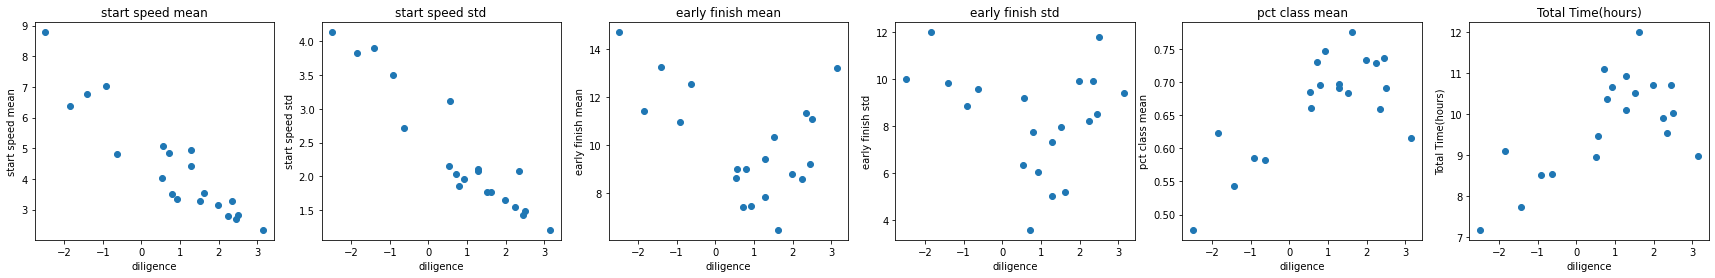

In [32]:
plt.figure(figsize=(30,4))
cols = ['start speed mean', 'start speed std', 'early finish mean', 'early finish std', 'pct class mean', 'Total Time(hours)']
xcol = 'diligence'
for i, ycol in enumerate(cols):
    plt.subplot(1,len(cols), i+1)
    x = sstats[ycol]
    y = sstats[xcol]
    plt.scatter(y, x)
    plt.title(ycol)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()



#### Off-task time

In [33]:
sid = sids[batch_descs[0]][0]

tx = get_tx(sid)
tx = lbl_nondil_tx(tx)

detect_offtask = calc_detected_offtask(tx)
detect_guess = calc_detected_guess(tx)
time_on_task = calc_time_on_task(tx)

sstats = pd.concat([sstats, \
                    detect_guess, detect_offtask, time_on_task], axis=1)
logger.info(f"Merged new stats together: {sstats.shape}")


INFO:analytics.batch:Merged new stats together: (20, 50)


##### Calculating off-task time

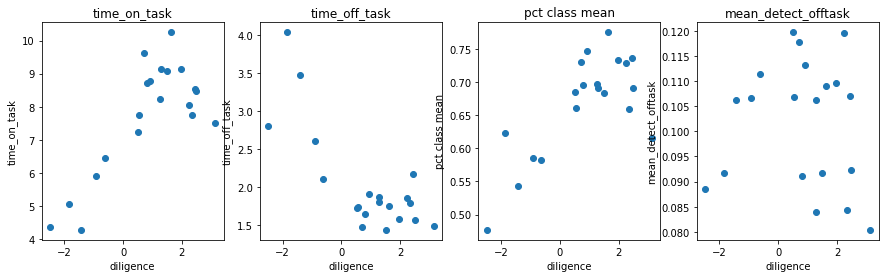

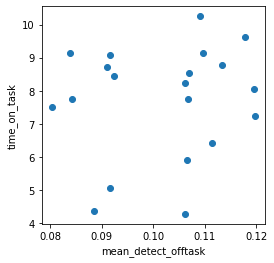

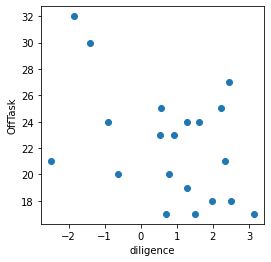

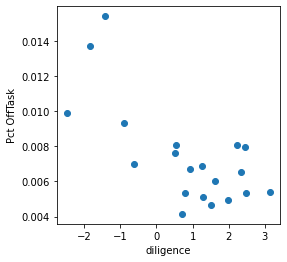

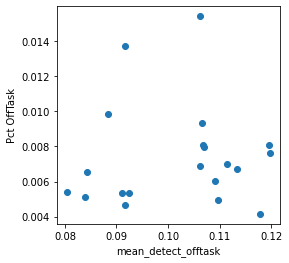

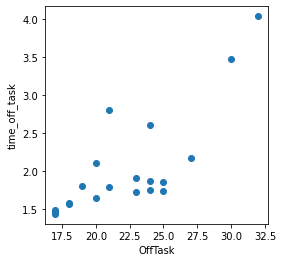

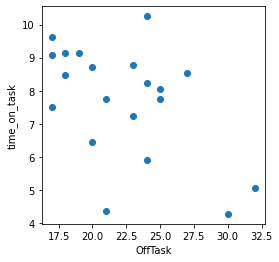

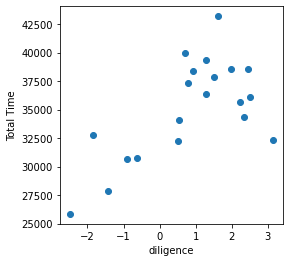

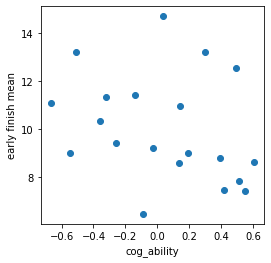

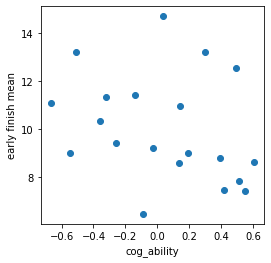

In [34]:
plt.figure(figsize=(15,4))
cols = ['time_on_task', 'time_off_task', 'pct class mean', 'mean_detect_offtask']
xcol = 'diligence'
for i, ycol in enumerate(cols):
    plt.subplot(1,len(cols), i+1)
    x = sstats[ycol]
    y = sstats[xcol]
    plt.scatter(y, x)
    plt.title(ycol)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
plt.show()

plots = [('mean_detect_offtask', 'time_on_task'), ('diligence', 'OffTask'),
         ('diligence', 'Pct OffTask'), ('mean_detect_offtask', 'Pct OffTask'),
         ('OffTask', 'time_off_task'), ('OffTask', 'time_on_task'),
         ('diligence', 'Total Time'), ('cog_ability', 'early finish mean'),
         ('cog_ability', 'early finish mean')
        ]

for xcol, ycol in plots:
    plt.figure(figsize=(4,4))
    x = sstats[xcol]
    y = sstats[ycol]
    plt.scatter(x, y)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()

Note: 

time_on_task calculation used pivot_table, but didn't specify an aggrigation function. Need to fix this in original script.

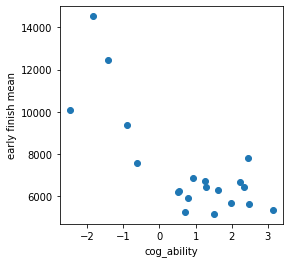

In [35]:
d = tx.groupby(['stu_id', 'is_offtask'])['duration'].sum().reset_index()
d = d.pivot(index='stu_id', columns='is_offtask', values='duration')

d = pd.concat([sstats['diligence'], d], axis=1)
plt.figure(figsize=(4,4))
x = d['diligence']
y = d[True]
plt.scatter(x, y)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.show()

In [36]:
#sstats = stu_stats[batch_descs[0]]

In [37]:
sid = sids[batch_descs[0]][0]

tx = get_tx(sid)
tx = lbl_nondil_tx(tx)

In [38]:
##### Accuracy

In [39]:

d = tx.groupby(['stu_id', 'outcome'])['_id'].count().reset_index(name="count").pivot_table(index='stu_id', columns='outcome', values='count', fill_value=0)
d['total tx'] = d.apply(lambda x: np.sum(x), axis=1)
d['accuracy'] = d.apply(lambda x: x['Correct'] / x['total tx'], axis=1)

sstats = pd.concat([sstats, d], axis=1)

#d = tx.pivot_table(index='stu_id', columns='outcome', values=t)

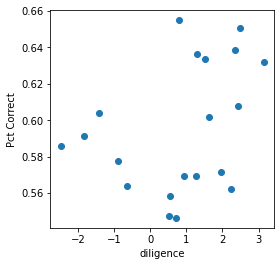

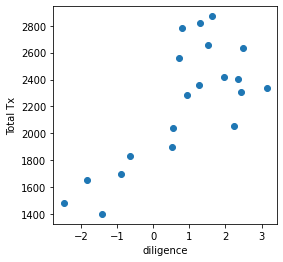

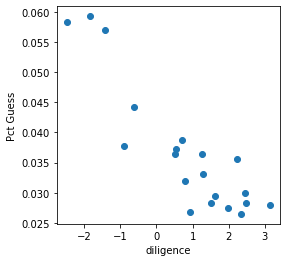

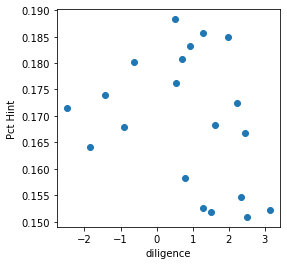

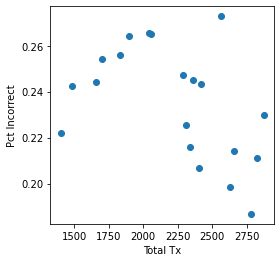

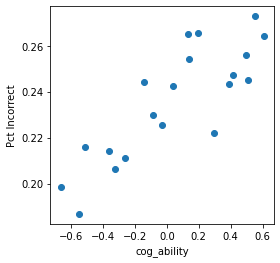

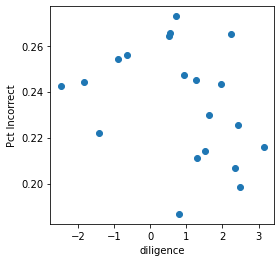

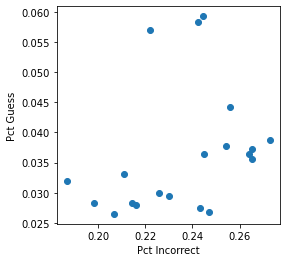

In [40]:
plots = [('diligence', 'Pct Correct'), ('diligence', 'Total Tx'), 
         ("diligence", "Pct Guess"), ('diligence', 'Pct Hint'),
         ('Total Tx', 'Pct Incorrect'), ('cog_ability', 'Pct Incorrect'),
         ('diligence', 'Pct Incorrect'), ("Pct Incorrect", "Pct Guess")
        ]

for xcol, ycol in plots:
    plt.figure(figsize=(4,4))
    x = sstats[ycol]
    y = sstats[xcol]
    plt.scatter(y, x)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()



In [41]:
logger.info(f"Number of High error rate students: {np.sum(sstats['Pct Incorrect'] > 0.2)}")

INFO:analytics.batch:Number of High error rate students: 18


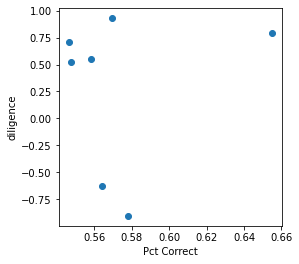

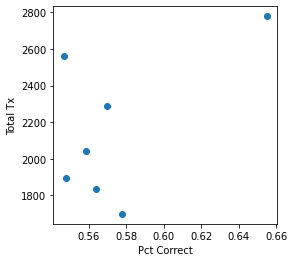

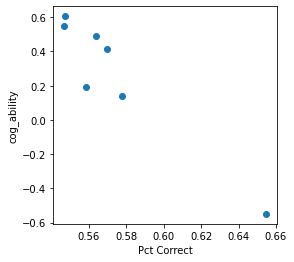

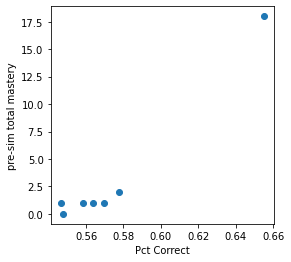

In [42]:
# EDA of students near diligence = 0 where there were strange discontinuities in behavior data
plots = [('diligence', 'Pct Correct'),
         ('Total Tx', 'Pct Correct'), ('cog_ability', 'Pct Correct'),
         ('pre-sim total mastery', 'Pct Correct')
        ]

rows = (sstats['diligence'] < 1) & (sstats['diligence'] > -1)

for ycol, xcol in plots:
    plt.figure(figsize=(4,4))
    x = sstats.loc[rows, ycol]
    y = sstats.loc[rows, xcol]
    plt.scatter(y, x)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()



### Domain

In [43]:
#

#### KC Parameter EDA

#### Tutor Skill Tracing

### Tutor

#### Knowledge Tracing

### Learning

#### Student learning

In [44]:
sid = sids[batch_descs[0]][0]

tx = get_tx(sid)

In [45]:
step_stats = tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].agg(['sum', 'count']).reset_index()
stu_prob_stats = step_stats.groupby('stu_id')['count'].describe()
stu_prob_stats.columns = ["Step Attempt %s" % col for col in stu_prob_stats.columns]
d = step_stats.groupby('stu_id')['sum'].describe()
d.columns = ["Step Duration %s" % col for col in d.columns]
stu_prob_stats = pd.concat([stu_prob_stats, d], axis=1)
stu_prob_stats.head()

# kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count()
stu_kc_stats = tx[['stu_id', 'kc', 'step_id']].drop_duplicates().groupby(['stu_id', 'kc']).count().reset_index()
stu_kc_stats.rename(columns={'step_id': 'kc opportunities'}, inplace=True)
kc_stats = stu_kc_stats.groupby('kc').describe()


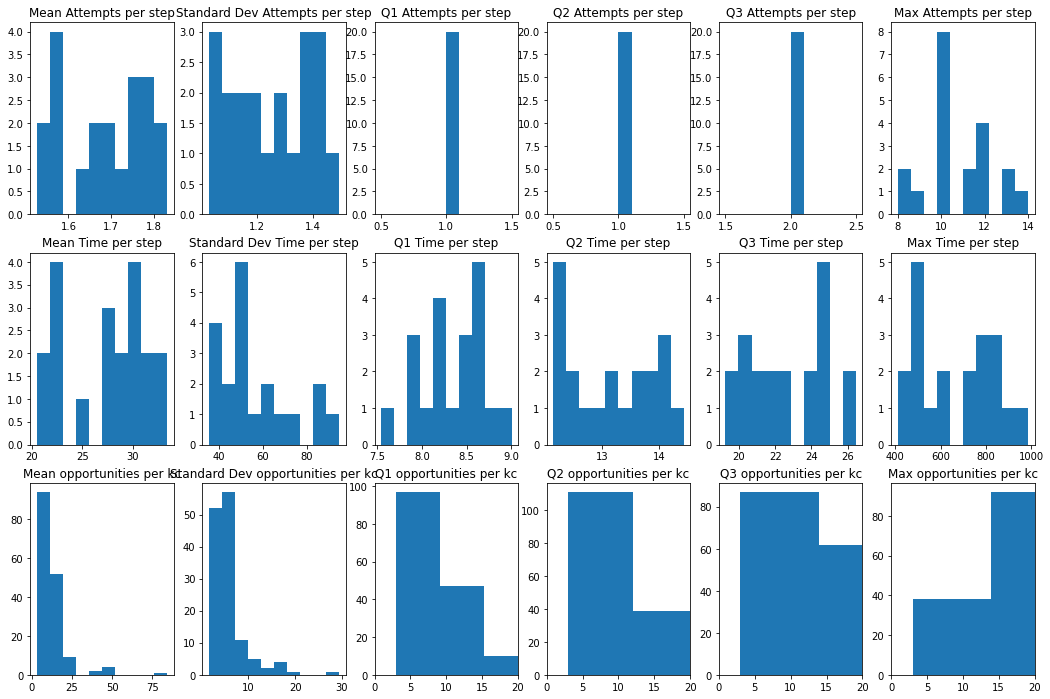

In [46]:
num_bins = 10
num_rows = 3
num_cols = 6
row_height = 3
col_width = 3
plt.figure(figsize=(col_width*num_cols, row_height*num_rows+num_rows))

row = 0
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Attempt mean'], bins=num_bins)
plt.title("Mean Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Attempt std'], bins=num_bins)
plt.title("Standard Dev Attempts per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Attempt 25%'], bins=num_bins)
plt.title("Q1 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Attempt 50%'], bins=num_bins)
plt.title("Q2 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Attempt 75%'], bins=num_bins)
plt.title("Q3 Attempts per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Attempt max'], bins=num_bins)
plt.title("Max Attempts per step")

row = 1
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(stu_prob_stats['Step Duration mean'], bins=num_bins)
plt.title("Mean Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(stu_prob_stats['Step Duration std'], bins=num_bins)
plt.title("Standard Dev Time per step")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
plt.hist(stu_prob_stats['Step Duration 25%'], bins=num_bins)
plt.title("Q1 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(stu_prob_stats['Step Duration 50%'], bins=num_bins)
plt.title("Q2 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(stu_prob_stats['Step Duration 75%'], bins=num_bins)
plt.title("Q3 Time per step")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(stu_prob_stats['Step Duration max'], bins=num_bins)
plt.title("Max Time per step")

row = 2
plt.subplot(num_rows,num_cols,num_cols*row + 1)
plt.hist(kc_stats[('kc opportunities', 'mean')], bins=num_bins)
plt.title("Mean opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 2)
plt.hist(kc_stats[('kc opportunities', 'std')], bins=num_bins)
plt.title("Standard Dev opportunities per kc")


plt.subplot(num_rows,num_cols,num_cols*row + 3)
axes = plt.hist(kc_stats[('kc opportunities', '25%')], bins=num_bins)
x1,x2,y1,y2 = plt.axis()
plt.axis([0,20,y1,y2])
plt.title("Q1 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 4)
plt.hist(kc_stats[('kc opportunities', '50%')], bins=num_bins)
x1,x2,y1,y2 = plt.axis()
plt.axis([0,20,y1,y2])
plt.title("Q2 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 5)
plt.hist(kc_stats[('kc opportunities', '75%')], bins=num_bins)
x1,x2,y1,y2 = plt.axis()
plt.axis([0,20,y1,y2])
plt.title("Q3 opportunities per kc")
plt.subplot(num_rows,num_cols,num_cols*row + 6)
plt.hist(kc_stats[('kc opportunities', 'max')], bins=num_bins)
x1,x2,y1,y2 = plt.axis()
plt.axis([0,20,y1,y2])
plt.title("Max opportunities per kc")

plt.show()

Notes:

- Tweaked m_t domain parameter so that skills are given more opportunities to mastery.
- Still need to investigate disconnects between tutor and student knowledge.

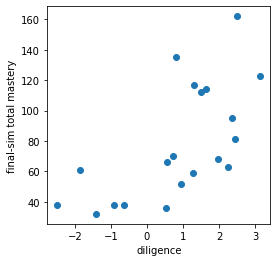

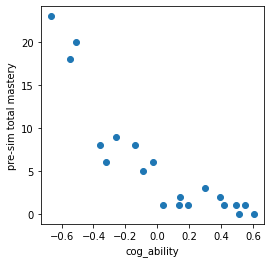

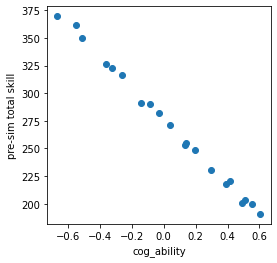

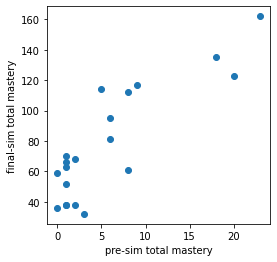

In [47]:
# EDA of aggregate student knowledge
plots = [('diligence', 'final-sim total mastery'), ('cog_ability', 'pre-sim total mastery'),
         ('cog_ability', 'pre-sim total skill'), ('pre-sim total mastery', 'final-sim total mastery')
        ]

for xcol, ycol in plots:
    plt.figure(figsize=(4,4))
    x = sstats[ycol]
    y = sstats[xcol]
    plt.scatter(y, x)
    plt.xlabel(xcol)
    plt.ylabel(ycol)
    plt.show()



In [48]:
# Look at accuracy of tutor knowledge tracing

In [49]:
tx_lblr = TransactionAnnotator(db)

In [50]:
def get_tx_actions(tx):
    d = tx.explode('action_ids').rename(columns={'action_ids': 'action_id'})
    actions = pd.DataFrame(db.actions.find({"_id": {"$in": d['action_id'].tolist()}}))
    actions['action_type'] = actions.apply(lambda x: x['action']['type'], axis=1)
    actions.rename(columns={"_id": "action_id"}, inplace=True)
    d = pd.merge(d[['_id', 'action_id']], actions, on='action_id', how='outer')
    return d

def label_offtask_tx(tx):
    d = tx.explode('action_ids')
    actions = pd.DataFrame(db.actions.find({"_id": {"$in": d['action_ids'].tolist()}}))
    actions['action_type'] = actions.apply(lambda x: x['action']['type'], axis=1)
    actions.rename(columns={"_id": "action_ids"}, inplace=True)
    d = pd.merge(d, actions[['action_ids', 'action_type']], on='action_ids', how='outer')
    return d.groupby("_id")['action_type'].apply(lambda x: "OffTask" in x.tolist())

def get_tx_decisions(tx, get_actions=True):
    actions = get_tx_actions(tx)
    decisions = pd.DataFrame(db.decisions.find({"_id": {"$in": actions['decision_id'].tolist()}}))
    decisions.rename(columns={"_id": "decision_id"}, inplace=True)
#    d = pd.merge(actions[['action_id', 'decision_id']], decisions, on='decision_id', how='outer')
    if get_actions:
        return decisions, actions
    else:
        return decisions


In [51]:
# Merge dcisions with tx
decisions, actions = tx_lblr.get_tx_decisions(tx)
# Need to remove "_id" from index because some transactions will be duplicated
tx.index = range(tx.shape[0])
actions.drop(columns=['time'], inplace=True)
d = pd.merge(tx, actions, how='outer', on='_id')
drop_cols = ['hints_avail', 'hints_used', 'attempt', 'student_id', 'kc']
decisions.drop(columns=drop_cols, inplace=True)
decisions.rename(columns={"time": "action_time"}, inplace=True)
d = pd.merge(d, decisions, how='outer', on='decision_id')
print(f"Original tx: {tx.shape}")
print(f"Decisions: {decisions.shape}")
print(f"Actions: {actions.shape}")
print(f"Merged. Multiple tx for tx where multiple actions are associated: {d.shape}")


Original tx: (44510, 19)
Decisions: (63238, 10)
Actions: (63238, 6)
Merged. Multiple tx for tx where multiple actions are associated: (63238, 33)


In [52]:
# Summarize student-kc
# Rollup steps


# Count outcomes
d1 = tx.pivot_table(index=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], columns=['outcome'], values='duration', aggfunc=len, fill_value=0)
print(d1.shape)
# Count actions
d1 = pd.concat([d1, d.pivot_table(index=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], columns=['action_type'], values='duration', aggfunc=len, fill_value=0)], axis=1)
print(d1.shape)
# Sum Time
d1 = pd.concat([d1, tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].sum()], axis=1)
print(d1.shape)
# Count Attempts
d1 = pd.concat([d1, tx.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['duration'].count().rename("Attempts")], axis=1)
print(d1.shape)
# Add Plt
d1 = pd.concat([d1, d.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['plt'].agg(lambda x: x.min())], axis=1)
print(d1.shape)
# Plt1
d1 = pd.concat([d1, d.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['plt1'].agg(lambda x: x.max())], axis=1)
print(d1.shape)
# Learner Knowledge changes after first attempt. 
d1 = pd.concat([d1, d.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['learner_knowledge'].agg(lambda x: x.iloc[0])], axis=1)
print(d1.shape)
# Get time stamp for last tx
d1 = pd.concat([d1, d.groupby(['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'])['time'].agg(lambda x: x.sort_values().iloc[-1])], axis=1)
print(d1.shape)

# Get constant fields
d1 = pd.merge(d1, d.loc[:, ['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id', 'kc' ]].drop_duplicates(), on=['stu_id', 'unit_id', 'section_id', 'prob_id', 'step_id'], how='inner')
print(d1.shape)
steps = d1.sort_values(by="time")

(26637, 3)
(26637, 8)
(26637, 9)
(26637, 10)
(26637, 11)
(26637, 12)
(26637, 13)
(26637, 14)
(26637, 20)


In [53]:
# KC Rollup
# Count opportunities
d1 = steps.groupby(['stu_id', 'kc'])['plt'].count().rename("opportunities")
# Last knowledge estimate
d1 = pd.concat([d1, steps.groupby(['stu_id', 'kc'])['plt1'].agg(lambda x: x.iloc[-1]).rename("last knowledge est")], axis=1)
# Max knowledge estimate
d1 = pd.concat([d1, steps.groupby(['stu_id', 'kc'])['plt1'].agg(lambda x: x.max()).rename("max knowledge est")], axis=1)
# Index of max knowledge estimate
d1 = pd.concat([d1, steps.groupby(['stu_id', 'kc'])['plt1'].agg(lambda x: x.tolist().index(x.max())).rename("max know opp")], axis=1)
# starting learner knowledge
d1 = pd.concat([d1, steps.groupby(['stu_id', 'kc'])['learner_knowledge'].agg(lambda x: x.iloc[0]).rename("init learner knowledge")], axis=1)
# final learner knowledge
d1 = pd.concat([d1, steps.groupby(['stu_id', 'kc'])['learner_knowledge'].agg(lambda x: x.iloc[-1]).rename("final learner knowledge")], axis=1)

kc_stats = d1.copy()


In [54]:
# EDA of challenge level of students
# Looking at how many practice opportunities students are getting at different levels of ability/knowledge

# Learner knowledge 

def label_knowledge(x):
    if x <= 0.3:
        return 'low_knowledge'
    elif (x > 0.3) and (x <= 0.5):
        return 'low-mid_knowledge'
    elif (x > 0.5) and (x <= 0.7):
        return 'mid_knowledge'
    elif (x > 0.7) and (x <= 0.9):
        return 'mid-high_knowledge'
    elif (x > 0.9):
        return 'high_knowledge'
    
new_cols = {'low_knowledge': (0, 0.2),
            'low-mid_knowledge': (0.3, 0.5), 
            'mid_knowledge': (0.5, 0.7), 
            'mid-high_knowledge': (0.7, 0.9),
            'high_knowledge': (0.9, 1)
           }

def label_knowledge(x):
    for k in new_cols:
        if (x <= new_cols[k][1]) & (x > new_cols[k][0]):
            return k



steps['knowledge_level'] = steps['learner_knowledge'].apply(label_knowledge)
steps = pd.concat([steps, pd.get_dummies(steps['knowledge_level'])], axis=1)

# Count opportunities at each knowledge level
d1 = steps.groupby('stu_id')['low_knowledge'].sum()
    
for col in new_cols:
    if col != 'low_knowledge':
        d1 = pd.concat([d1, steps.groupby('stu_id')[col].sum()], axis=1)



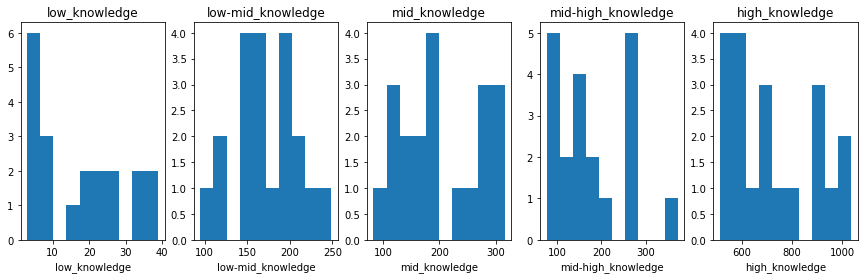

In [55]:
# Plot counts of students at varying degrees of practice at each level of knowledge
plt.figure(figsize=(15,4))    
for i, col in enumerate(new_cols):
    plt.subplot(1,len(new_cols), i+1)
    plt.hist(d1[col])
    plt.xlabel(col)
    plt.title(col)

plt.show()

##### Help-seeking

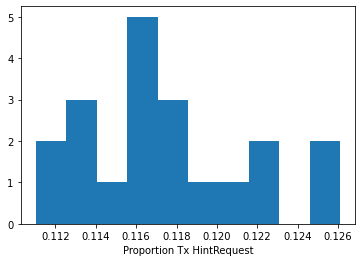

<function matplotlib.pyplot.show(close=None, block=None)>

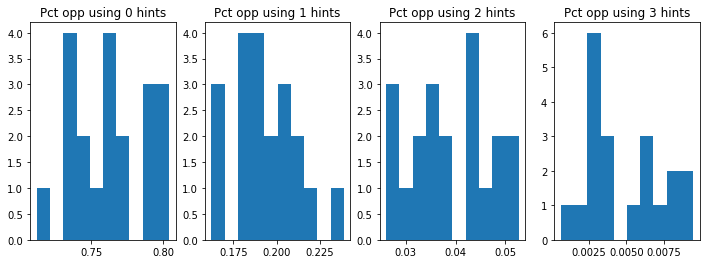

In [56]:
# Overall Help-seeking
plt.hist(sstats['Pct HintRequest'])
plt.xlabel("Proportion Tx HintRequest")
plt.show()

# Total Hints used per opportunity
d1 = steps.pivot_table(index='stu_id', columns='Hint', values='Attempt', aggfunc='count', fill_value=0)
d1['total'] = d1.apply(lambda x: np.sum(x), axis=1)
for col in d1.columns:
    if col != 'total':
        d1[col] = d1[col] / d1['total']


l = len(d1.columns) - 1
plt.figure(figsize=(12,4))
for i, col in enumerate(d1.columns[:-1]):
    plt.subplot(1, l, i+1)
    plt.hist(d1[col])
    plt.title(f"Pct opp using {col} hints")
#d1.head()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

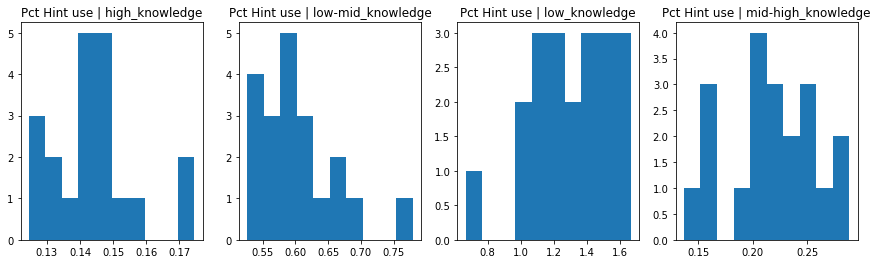

In [57]:
# Help-seeking | learner_knowledge

d1 = steps.groupby(['stu_id', 'knowledge_level'])['Hint'].mean().unstack(fill_value=0)
#d1.head()

l = len(d1.columns) - 1
plt.figure(figsize=(15,4))
for i, col in enumerate(d1.columns[:-1]):
    plt.subplot(1, l, i+1)
    plt.hist(d1[col])
    plt.title(f"Pct Hint use | {col}")

plt.show